# Tracking particles in brightfield

**TL;DR** We developed a new method to more accurately track colloidal particles in bright field images that do not resemble Gaussian features.

The standard `locate` function in `trackpy` finds features by determining local maxima of intensity, thereby assuming the particles that need to be tracked have a Gaussian intensity distribution with a maximum in the center. While this is usually true for fluorescent particles, particles in bright field mode show a different intensity profile (see example images in this notebook).

Because the intensity profile is usually different from a Gaussian in bright field mode, the `locate` function fails to accurately find the center of the particle. We have developed a new method that uses the edge of the particle to more accurately refine the position of the center of the particle as detected by the standard `locate` function.

**Citing this work**
The algorithm we'll use is described in the following paper:
"Colloid supported lipid bilayers for self-assembly", M. Rinaldin, R.W. Verweij, I. Chakrabory, D.J. Kraft, Soft Matter (2019) [https://doi.org/10.1039/c8sm01661e](https://doi.org/10.1039/c8sm01661e). It is implemented in `trackpy` as `locate_brightfield_ring`. If you're using this code in your work, please cite both the paper and the appropriate `trackpy` version.

## Preliminary imports

In [20]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

We also might want to use scientific Python libraries. Finally, we'll import ``trackpy`` itself and its sister project, `pims`.

In [21]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

## Step 1: Read the Data

### Opening images or video

We open the files with `pims`:

In [25]:
frames = pims.ImageSequence('../sample_data/brightfield/*.png', as_grey=True)

In [26]:
micron_per_pixel = 0.15192872980868
feature_diameter = 2.12 # um
radius = int(np.round(feature_diameter/2.0/micron_per_pixel))
if radius % 2 == 0:
    radius += 1
print('Using a radius of {:d} px'.format(radius))
frames

Using a radius of 7 px


<Frames>
Source: /home/ruben/repositories/trackpy-examples/sample_data/brightfield/*.png
Length: 50 frames
Frame Shape: (500, 500)
Pixel Datatype: uint8

These are colloidal particles diffusing in quasi-2D on a substrate. The images are cropped to focus on just five particles for 50 frames (approximately 7 seconds). Let's have a look a the first frame:

Frame([[139, 137, 137, ..., 142, 142, 143],
       [137, 134, 136, ..., 141, 143, 143],
       [135, 138, 134, ..., 140, 144, 139],
       ...,
       [146, 146, 143, ..., 154, 155, 156],
       [148, 147, 144, ..., 154, 153, 152],
       [146, 145, 146, ..., 151, 154, 149]], dtype=uint8)
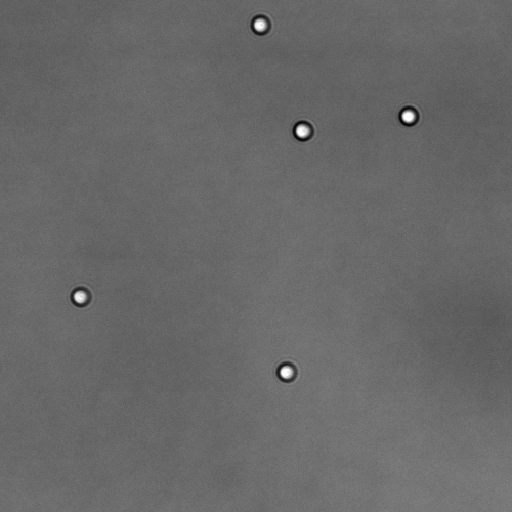

In [28]:
frames[0]

## Step 2: Locate Features

### Using the locate function

First, we'll try the standard `locate` function to find the particle positions:

In [29]:
# we use a slightly larger radius
f_locate = tp.locate(frames[0], radius+2, minmass=300)

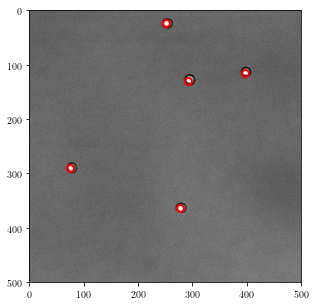

In [30]:
tp.annotate(f_locate, frames[0], plot_style={'markersize': radius});

Let's zoom in a bit more on the three particles in the top right corner:

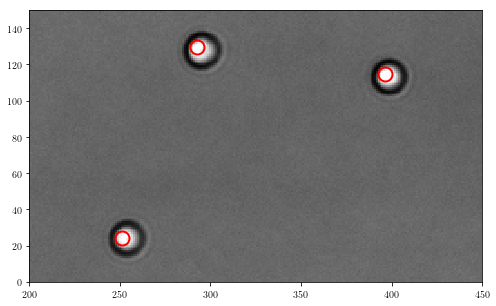

In [32]:
plt.figure()
tp.annotate(f_locate, frames[0], plot_style={'markersize': radius*2}, ax=plt.gca())
plt.ylim(0, 150)
plt.xlim(200, 450);

All positions seem to be slightly displaced from the center! This is because `locate` assumes each particle to be a Gaussian feature (as is the case for e.g. fluorescent particles), while in this case that does not describe our data well.

### Using the locate_brightfield_ring function

Now, we'll try the `locate_brightfield_ring` function to find the particle positions. Instead of finding a Gaussian maximum, this makes the following assumptions:

1. The particle is bright on a dark background
2. There is a dark ring around the bright particle

The position is located by first using the standard `locate` function as an initial guess and subsequently refined by finding the dark edge around the particle.

In [33]:
# we use a slightly larger radius
f_bf = tp.locate_brightfield_ring(frames[0], 2.0*radius+1)

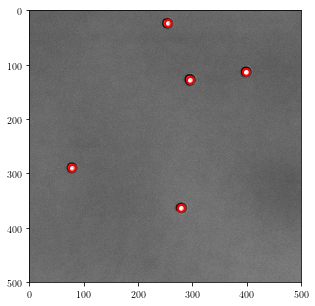

In [34]:
tp.annotate(f_bf, frames[0], plot_style={'markersize': radius});

Let's zoom in a bit more on the three particles in the top right corner again:

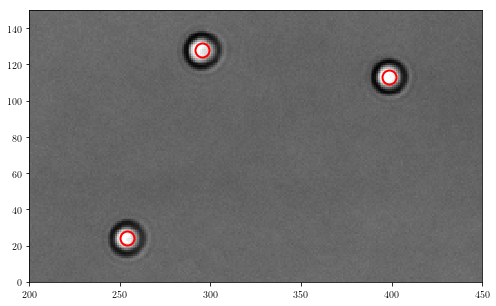

In [35]:
plt.figure()
tp.annotate(f_bf, frames[0], plot_style={'markersize': radius*2}, ax=plt.gca())
plt.ylim(0, 150)
plt.xlim(200, 450);

While the function can run without the `previous_coords` argument, it is usually fastest to supply the initial positions yourself, because the exact parameters we have to pass to the locate function depend on the type of image.

Here, we'll use our previous result `f_locate` as an initial guess:

In [40]:
# we use a slightly larger radius
f_bf_with_prev = tp.locate_brightfield_ring(frames[0], 2.0*radius+1, previous_coords=f_locate)

### Comparison of the three methods

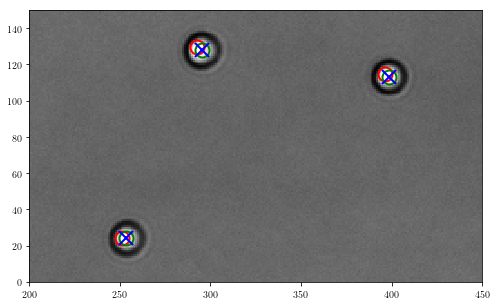

In [57]:
plot_properties = dict(markeredgewidth=2, markersize=radius*2, markerfacecolor='none')

plt.figure()
plt.imshow(frames[0])
plt.plot(f_locate['x'], f_locate['y'], 'o', markeredgecolor='red', **plot_properties)
plt.plot(f_bf['x'], f_bf['y'], 'o', markeredgecolor='green', **plot_properties)
plt.plot(f_bf_with_prev['x'], f_bf_with_prev['y'], 'x', markeredgecolor='blue', **plot_properties)
plt.ylim(0, 150)
plt.xlim(200, 450);

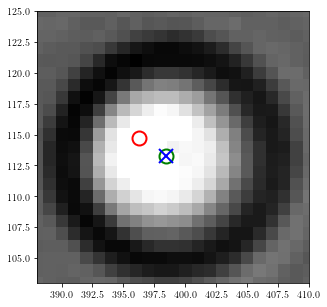

In [58]:
plt.figure()
plt.imshow(frames[0])
plt.plot(f_locate['x'], f_locate['y'], 'o', markeredgecolor='red', **plot_properties)
plt.plot(f_bf['x'], f_bf['y'], 'o', markeredgecolor='green', **plot_properties)
plt.plot(f_bf_with_prev['x'], f_bf_with_prev['y'], 'x', markeredgecolor='blue', **plot_properties)
plt.ylim(103, 125)
plt.xlim(388, 410);

As can be seen, the position found with `locate_brightfield_ring` is more accurate than with the standard `locate` function. Also, the positions of `locate_brightfield_ring` with or without initial positions overlap nicely.

## Step 3: Linking particle positions from all frames into trajectories

To track particles from all frames and link them into trajectories, we simply repeatedly call the `locate_brightfield_ring` function for all frames. We supply the positions of the previous frame as `previous_coords` and the linking happens automatically (for small enough displacements between frames).

In [73]:
trajectories = []

# Take only the x and y positions from the standard `locate` function
previous_coords = f_locate[['x', 'y']].copy()

# Store the radius
previous_coords['r'] = radius

# Number the particles, this will get copied for all frames
previous_coords['particle'] = np.arange(0, len(f_locate), 1)

for frame in frames:
    # The radius of the particle is fixed, but the radius of the feature can change based on focal plane
    average_radius = np.mean(previous_coords['r'])
    
    # Locate particles in this frame based on the previous positions
    f_bf = tp.locate_brightfield_ring(frame, 2.0*average_radius+1, previous_coords=previous_coords)
    
    # Store the result
    trajectories.append(f_bf)
    
    # Store the previous positions
    previous_coords = f_bf

# Merge all into one dataframe
trajectories = pd.concat(trajectories, sort=True)

   frame  particle         r           x          y
0      0       0.0  8.044295  253.503980  24.062736
0      1       0.0  8.422858  252.912288  24.238158
0      2       0.0  8.284869  253.278434  23.281073
0      3       0.0  8.357622  254.117170  22.490610
0      4       0.0  8.388968  253.600409  23.153173
0      5       0.0  8.419871  253.064242  22.852294
0      6       0.0  8.466514  253.286044  23.444700
0      7       0.0  8.497042  253.107654  24.045086
0      8       0.0  8.331211  254.499340  24.693404
0      9       0.0  8.448362  254.884995  24.208861


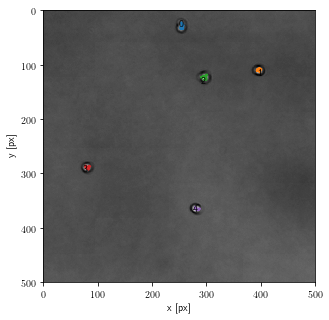

In [78]:
# Inspect the position in the first 10 frames for particle 0
print(trajectories[trajectories['particle']==0].head(10))

# Overlay trajectories on average of all frames
background = np.mean(frames, axis=0)
tp.plot_traj(trajectories, superimpose=background, label=True, plot_style={'linewidth': 2});

All particle trajectories seem to be tracked. Let's zoom in a bit more to verify this:

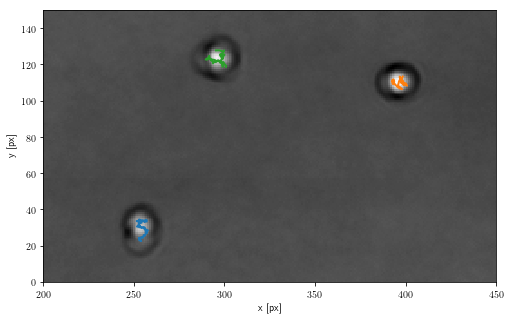

In [77]:
plt.figure()
background = np.mean(frames, axis=0)
tp.plot_traj(trajectories, superimpose=background, ax=plt.gca(), plot_style={'linewidth': 2})
plt.ylim(0, 150)
plt.xlim(200, 450);

Alternatively, you can use [Pimsviewer](https://github.com/soft-matter/pimsviewer#example-03-annotating-features-on-a-video) to overlay the positions on your video to check if the tracking has succeeded. Now you can analyse your data using the accurate center positions of the particles.

# About this work

This tutorial was written by Ruben Verweij, as part of his PhD thesis in Daniela Kraft’s group at the Huygens-Kamerlingh-Onnes laboratory, Institute of Physics, Leiden University, The Netherlands. This work was supported by the Netherlands Organisation for Scientific Research (NWO/OCW) and the European Research Council (ERC).

**Citing this work**
The algorithm is described in the following paper:
"Colloid supported lipid bilayers for self-assembly", M. Rinaldin, R.W. Verweij, I. Chakrabory, D.J. Kraft, Soft Matter (2019) [https://doi.org/10.1039/c8sm01661e](https://doi.org/10.1039/c8sm01661e). It is implemented in `trackpy` as `locate_brightfield_ring`. If you're using this code in your work, please cite both the paper and the appropriate `trackpy` version.